### Build

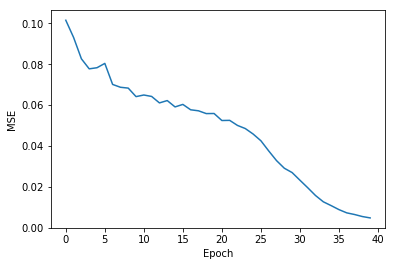

In [11]:
from dependencies import *              # imports  all functions in dependencies.py
from matplotlib import pyplot as plt

# Set the seed for random number generator (Important for weight initialization)

seed = 28

np.random.seed(seed)

#%% Parameters

units_perdim = 3    # features per dimension  (default: 3)

input_dim = 3       # input dimensions (default: 3)

output_dim = 3      # output dimensions (default: 3)


alpha = 0.3         # Learning rate

bias = 0           # bias weight

simult = 2          # number of task to be performed simultaneously (1 for single tasks)


#%% Netwwork structure

# Input layer

input_units = units_perdim*input_dim


# Output layer

output_units = units_perdim*output_dim


# Task Layer

task_units = input_dim*output_dim   # all possible input-output mappings


# Hidden layer

hidden_units = input_units*output_units # enough to not force the network to generalize
                                        # could use some other formula or set an integer 


#Initialize Weights
    
(w_IH, w_HO, w_TH, w_TO, bias_H, bias_O) = init_weights(input_units, hidden_units, output_units, task_units, bias)

        # go to function init_weights() in dependencies.py


#%% Generate patterns

input_patterns = get_inputPatterns(units_perdim, input_dim)

tasks, task_map = get_taskPatterns(input_dim, output_dim)


#%% Initialize Logs per epoch of training

E_log = []          # Error per pattern 
MSE_log = []        # Mean Squared Error
input_log = []      # Input patterns
hidden_log = []     # Hidden actvity
output_log = []     # Output patterns
target_log = []     # Expected output patterns
io_map_log = []     # Task input-output maps
tasks_log = []      # Task patterns

# weight logs include initial values (bias weights not learned /  same across epochs)

w_IH_log = [w_IH]   # w_IH from init_weights
w_HO_log = [w_HO]
w_TH_log = [w_TH]
w_TO_log = [w_TO]


#%% Train Network

train = True
hard_stop = 600    # Makes sure the code does not run forever if the network does not learn
iterations = 0     # counts the number of training sessions

while train:
    
    # Randomize input and task patterns
    
    in_patterns = input_patterns[np.random.permutation(len(input_patterns))]
    tasks_perm = tasks[np.random.permutation(len(tasks))].reshape((len(tasks), -1))
    
    # Generate target patterns
    
    target_patterns, task_patterns, io_map, patterns = get_trainPatterns(in_patterns, tasks_perm, units_perdim, output_dim, task_map)
    
            # go to get_trainPatterns() in dependencies.py
    
    target_log += [target_patterns]
    tasks_log += [task_patterns]
    io_map_log += [io_map]
    input_log += [patterns]
    
    
    # Set trials for training epoch
    
    trials = len(target_patterns)
    
    E = np.zeros((trials, output_units))
    output_patterns = np.zeros((trials, output_units))
    hidden_patterns = np.zeros((trials, hidden_units))
    
    
    # Start epoch
    
    for trial in range(trials):

        # Compute activity for hidden and output layers
    
        hidden_net = np.reshape(patterns[trial], (1, -1)) @ w_IH + np.reshape(task_patterns[trial], (1, -1)) @ w_TH + np.reshape(bias_H, (1, -1))
    
                # net input = input x weights 
                # (i.e. input layer x weights input layer to hidden layer, here in matrix notation)
                # add input from all layers with inputs to hidden (i.e. input, task, and bias layer)
    
        hidden_act  = activity(hidden_net)
        
                # go to activity() in dependencies.py
        
        hidden_patterns[trial] = hidden_act
        
        output_net = hidden_act @ w_HO + np.reshape(task_patterns[trial], (1, -1)) @ w_TO + np.reshape(bias_O, (1, -1))
        
                # same as in hidden_net
    
        output_act = activity(output_net)
    
                # same as in hidden_act
        
        output_patterns[trial] = output_act
    
        
        # Compute error and deltas  (for Backprop)
        
        E[trial] = output_act - target_patterns[trial]
                     
        delta_out = activity(output_net, derive = True)*E[trial]
        
                # go to activity() in dependencies.py when derive = True
                # delta_out = f_act`(output_net)*error (from backprop rule)
        
        delta_hidden = activity(hidden_net, derive = True)*(delta_out @ np.transpose(w_HO))    
                
                # follows logic from delta_out for an inner layer in a 2 layered network
        
        
        # Compute error gradient
        
        dE_wHO = gradient(hidden_act, delta_out)
        
                # go to gradient() in dependencies.py
    
        dE_wIH = gradient(np.reshape(patterns[trial], (1, -1)), delta_hidden)
        
        dE_wCO = gradient(np.reshape(task_patterns[trial], (1, -1)), delta_out)
        
        dE_wCH = gradient(np.reshape(task_patterns[trial], (1, -1)), delta_hidden)
        
        
        # Modify Weights
        
        w_HO = delta_W(alpha, w_HO, dE_wHO)
        
                # go to delta_W() in dependencies.py
        
        w_IH = delta_W(alpha, w_IH, dE_wIH)
        
        w_TO = delta_W(alpha, w_TO, dE_wCO)
        
        w_TH = delta_W(alpha, w_TH, dE_wCH)
    
    
    # Update Logs
    
    hidden_log += [hidden_patterns]
    output_log += [output_patterns]
    E_log += [E]
    MSE_log += [np.mean(E**2)]
    w_IH_log += [w_IH]
    w_HO_log += [w_HO]
    w_TH_log += [w_TH]
    w_TO_log += [w_TO]
    
    
    # Stop Training
    
    iterations += 1
    
    if MSE_log[-1] <= 0.005:
        
        train = False
    
    elif iterations == hard_stop:
        train = False


#%% Export relevant variables (Network structure and Weight logs)

import pickle

        # Feel free to modify name of the file

with open('model.pickle', 'wb') as handle:
    pickle.dump([units_perdim, input_dim, output_dim, w_IH_log, w_HO_log, w_TH_log, w_TO_log, bias_H, bias_O], handle, protocol = pickle.HIGHEST_PROTOCOL)

    
#%% Visualize Learning

plt.figure('Network Training')
plt.plot(MSE_log)
plt.xlabel('Epoch')
plt.ylabel('MSE') 
plt.show()